In [1]:
import os
import math
from datetime import datetime, timedelta

import matplotlib as mpl
from matplotlib import pyplot, gridspec
from matplotlib.ticker import MultipleLocator, NullFormatter, ScalarFormatter

from metpy import plots, calc
from metpy.units import units

import numpy as np

import pyart

import profile_io as io


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def plot_skewT(profile1, profile2, profile3, title,
                subplot_idx,
                fig,
                comp_pressure=None, comp_dewpoint=None, top_pressure=200, bottom_pressure=1050,
                profile1_barb_skip=20, profile2_barb_skip=20, profile3_barb_skip=1,
                vert_dim='model_level_number', **kwargs):

    """
    Plot a skew T plot with optional profile.

    Arguments:
        - **kwargs: Optional extra arguments to cape_func or to metpy.plots.SkewT.
    """

    # New blank skew T plot.
    skew = plots.SkewT(fig, subplot=subplot_idx, **kwargs)

    # Plot environmental temperature.
    skew.plot(pressure = profile1['pres'], t = profile1['tmpc'], 
            color = 'r', linewidth = 1.5)
    skew.plot(pressure = profile2['pres'], t = profile2['tmpc'], 
            color = 'b', linewidth = 1.5)
    if profile3:
        skew.plot(pressure = profile3['pres'], t = profile3['tmpc'], 
                color = 'k', linewidth = 1.5)

    # Plot dewpoint.
    skew.plot(pressure = profile1['pres'], t = profile1['dwpc'],
            color = 'r', linewidth = 1)
    skew.plot(pressure = profile2['pres'], t = profile2['dwpc'],
            color = 'b', linewidth = 1)
    if profile3:
        skew.plot(pressure = profile3['pres'], t = profile3['dwpc'], 
                color = 'k', linewidth = 1, linestyle = ':')
    
    # Plot wind.
    skew.plot_barbs(pressure=profile1['pres'][::profile1_barb_skip],
                    u=profile1['wind_u'][::profile1_barb_skip],
                    v=profile1['wind_v'][::profile1_barb_skip],
                    xloc=0.84, y_clip_radius=0.01, linewidth = 1.0, color = 'r')

    skew.plot_barbs(pressure=profile2['pres'][::profile2_barb_skip],
                    u=profile2['wind_u'][::profile2_barb_skip],
                    v=profile2['wind_v'][::profile2_barb_skip],
                    xloc=0.76, y_clip_radius=0.01, linewidth = 1.0, color = 'b')    
    if profile3:    
        skew.plot_barbs(pressure=profile3['pres'][::profile3_barb_skip],
                        u=profile3['wind_u'][::profile3_barb_skip],
                        v=profile3['wind_v'][::profile3_barb_skip],
                        xloc=0.96, y_clip_radius=0.01, linewidth = 0.5, color = 'k')                    

    # Add labels.
    pyplot.ylim(bottom_pressure, top_pressure)
    pyplot.xlim(-10, 40)
    pyplot.xlabel('Temperature ($^{\circ}$C)')
    pyplot.ylabel('Pressure (hPa)')
    pyplot.title(title)

In [6]:
#config for dataset
dataset1_config = {'split':271,'sondeid':'9931','timestamp':'2023-07-24_1631'}
dataset2_config = {'split':220,'sondeid':'9935','timestamp':'2023-07-24_1636'}

#set dataset
dataset_config = dataset1_config

#read data
row_to_split_profile = dataset_config['split']
timestamp = dataset_config['timestamp']
sonde_id = dataset_config['sondeid']
filename = f'/g/data/kl02/jss548/hail-research/hailsonde/20230724_hailsonde/{timestamp}_{sonde_id}.raw_flight_history.csv'
with_balloon_profile, no_balloon_profile, metadata = io.decode_raw_flight_history(filename, split=row_to_split_profile)

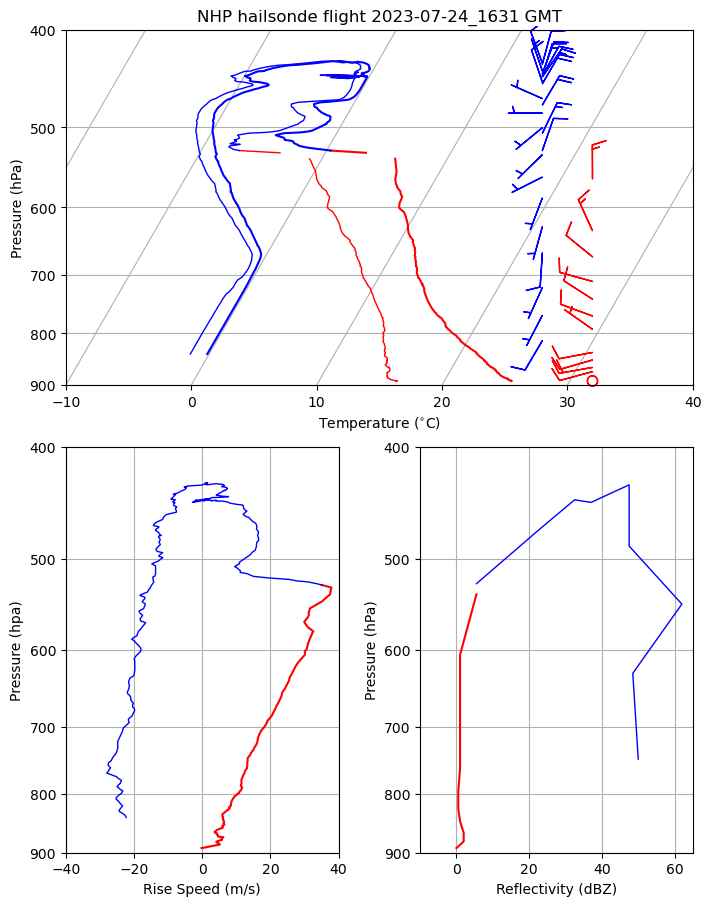

In [7]:
radar_site_alt = 810 #m 
bottom_pressure = 900
top_pressure = 400
radar_id = 2
gmt_offset = -6
radar_vols_path = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset'
output_image_path = '/g/data/kl02/jss548/hail-research/hailsonde/nhp_output'

#create figure and axes
fig = pyplot.figure(constrained_layout = True, figsize = (7, 9))
gs = fig.add_gridspec(2, 2)

#get location and time
snd_lat = with_balloon_profile['lat'][0]
snd_lon = with_balloon_profile['lon'][0]
snd_start_dt = datetime.strptime(os.path.basename(filename)[0:15], '%Y-%m-%d_%H%M') - timedelta(hours = gmt_offset) #MUST BE UTC+0 TIME

#get access-g data
# accessg_profile = io.get_accessg_profile(snd_start_dt, snd_lat, snd_lon)

#plot skewT profiles
plot_skewT(with_balloon_profile, no_balloon_profile, None,
                f'NHP hailsonde flight {timestamp} GMT',
                subplot_idx=gs[0, :],
                fig=fig,
                top_pressure=top_pressure, bottom_pressure=bottom_pressure,
                vert_dim='altitude above MSL (m)')

#plot rise speed
ax1 = fig.add_subplot(gs[1, 0])
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.yaxis.set_major_locator(MultipleLocator(100))
ax1.yaxis.set_minor_formatter(NullFormatter())
ax1.plot(with_balloon_profile['rise'], with_balloon_profile['pres'], color='r', linewidth=1.5)
ax1.plot(no_balloon_profile['rise'], no_balloon_profile['pres'], color='b', linewidth=1)
ax1.set_xlabel('Rise Speed (m/s)')
ax1.set_ylabel('Pressure (hpa)')
ax1.grid()
ax1.set_xlim((-40,40))
ax1.set_ylim((bottom_pressure, top_pressure))

#plot reflectivity profile

#init plot
ax2 = fig.add_subplot(gs[1, 1])
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.yaxis.set_major_locator(MultipleLocator(100))
ax2.yaxis.set_minor_formatter(NullFormatter())

#init ascent profile for radar matching
nan_filter = ~np.isnan(with_balloon_profile['lat'])
array_length = len(with_balloon_profile['hght'][nan_filter])
skip = round(array_length/10)
alt_refl_profile1 = with_balloon_profile['hght']._magnitude[nan_filter][::skip]
pres_refl_profile1 = with_balloon_profile['pres']._magnitude[nan_filter][::skip]
lat_refl_profile1 = with_balloon_profile['lat'][nan_filter][::skip]
lon_refl_profile1 = with_balloon_profile['lon'][nan_filter][::skip]
time_refl_profile1 = with_balloon_profile['time'][nan_filter][::skip]
radar_refl_profile1 = np.zeros_like(alt_refl_profile1, dtype=float)
radar_zdr_profile1 = np.zeros_like(alt_refl_profile1, dtype=float)
radar_kdp_profile1 = np.zeros_like(alt_refl_profile1, dtype=float)
radar_rhv_profile1 = np.zeros_like(alt_refl_profile1, dtype=float)

#init descent profile for radar matching
nan_filter = ~np.isnan(no_balloon_profile['lat'])
array_length = len(no_balloon_profile['hght'][nan_filter])
skip = round(array_length/10)
alt_refl_profile2 = no_balloon_profile['hght']._magnitude[nan_filter][::skip]
pres_refl_profile2 = no_balloon_profile['pres']._magnitude[nan_filter][::skip]
lat_refl_profile2 = no_balloon_profile['lat'][nan_filter][::skip]
lon_refl_profile2 = no_balloon_profile['lon'][nan_filter][::skip]
time_refl_profile2 = no_balloon_profile['time'][nan_filter][::skip]
radar_refl_profile2 = np.zeros_like(alt_refl_profile2, dtype=float)
radar_zdr_profile2 = np.zeros_like(alt_refl_profile2, dtype=float)
radar_kdp_profile2 = np.zeros_like(alt_refl_profile2, dtype=float)
radar_rhv_profile2 = np.zeros_like(alt_refl_profile2, dtype=float)

#load radar data
#snd_end_dt = snd_start_dt + timedelta(seconds=time_refl_profile2[-1])
radars, radar_dt_list = io.load_nhp_radar_data(radar_vols_path, 360)

#match ascent profile to radar data
for i in range(len(alt_refl_profile1)):
    profile1_target_dt = snd_start_dt + timedelta(seconds = time_refl_profile1[i])
    profile1_radar_idx = io.find_nearest_dt_idx(profile1_target_dt, radar_dt_list)

    gate_lon = radars[profile1_radar_idx].gate_longitude['data']
    gate_lat = radars[profile1_radar_idx].gate_latitude['data']
    gate_alt = radars[profile1_radar_idx].gate_altitude['data'] + radar_site_alt
    gate_refl = radars[profile1_radar_idx].fields['DBZH']['data'].data
    gate_zdr = radars[profile1_radar_idx].fields['ZDR']['data'].data
    gate_kdp = radars[profile1_radar_idx].fields['KDP']['data'].data
    gate_rhv = radars[profile1_radar_idx].fields['RHOHV']['data'].data

    dist = np.sqrt((io.degrees2meters(gate_lat - lat_refl_profile1[i]))**2 + (io.degrees2meters(gate_lon - lon_refl_profile1[i]))**2 + (gate_alt - alt_refl_profile1[i])**2)
    min_dist_idx = np.unravel_index(np.abs(dist).argmin(), gate_refl.shape)
    radar_refl_profile1[i] = gate_refl[min_dist_idx]
    radar_zdr_profile1[i] = gate_zdr[min_dist_idx]
    radar_kdp_profile1[i] = gate_kdp[min_dist_idx]
    radar_rhv_profile1[i] = gate_rhv[min_dist_idx]

#match descemt profile to radar data
for i in range(len(alt_refl_profile2)):

    profile2_target_dt = snd_start_dt + timedelta(seconds = time_refl_profile2[i])
    profile2_radar_idx = io.find_nearest_dt_idx(profile2_target_dt, radar_dt_list)

    gate_lon = radars[profile2_radar_idx].gate_longitude['data']
    gate_lat = radars[profile2_radar_idx].gate_latitude['data']
    gate_alt = radars[profile2_radar_idx].gate_altitude['data'] + radar_site_alt
    gate_refl = radars[profile2_radar_idx].fields['DBZH']['data'].data
    gate_zdr = radars[profile2_radar_idx].fields['ZDR']['data'].data
    gate_kdp = radars[profile2_radar_idx].fields['KDP']['data'].data
    gate_rhv = radars[profile2_radar_idx].fields['RHOHV']['data'].data

    dist = np.sqrt((io.degrees2meters(gate_lat - lat_refl_profile2[i]))**2 + (io.degrees2meters(gate_lon - lon_refl_profile2[i]))**2 + (gate_alt - alt_refl_profile2[i])**2)
    min_dist_idx = np.unravel_index(np.abs(dist).argmin(), gate_refl.shape)
    radar_refl_profile2[i] = gate_refl[min_dist_idx]  
    radar_zdr_profile2[i] = gate_zdr[min_dist_idx]
    radar_kdp_profile2[i] = gate_kdp[min_dist_idx]
    radar_rhv_profile2[i] = gate_rhv[min_dist_idx]    

ax2.plot(radar_refl_profile1, pres_refl_profile1, color='r', linewidth=1.5)
ax2.plot(radar_refl_profile2, pres_refl_profile2, color='b', linewidth=1)
ax2.set_xlabel('Reflectivity (dBZ)')
ax2.set_ylabel('Pressure (hPa)')
ax2.grid()
ax2.set_xlim((-10,65))
ax2.set_ylim((bottom_pressure, top_pressure))

pyplot.savefig(f'{output_image_path}/{sonde_id}_hailsonde_profile.png')


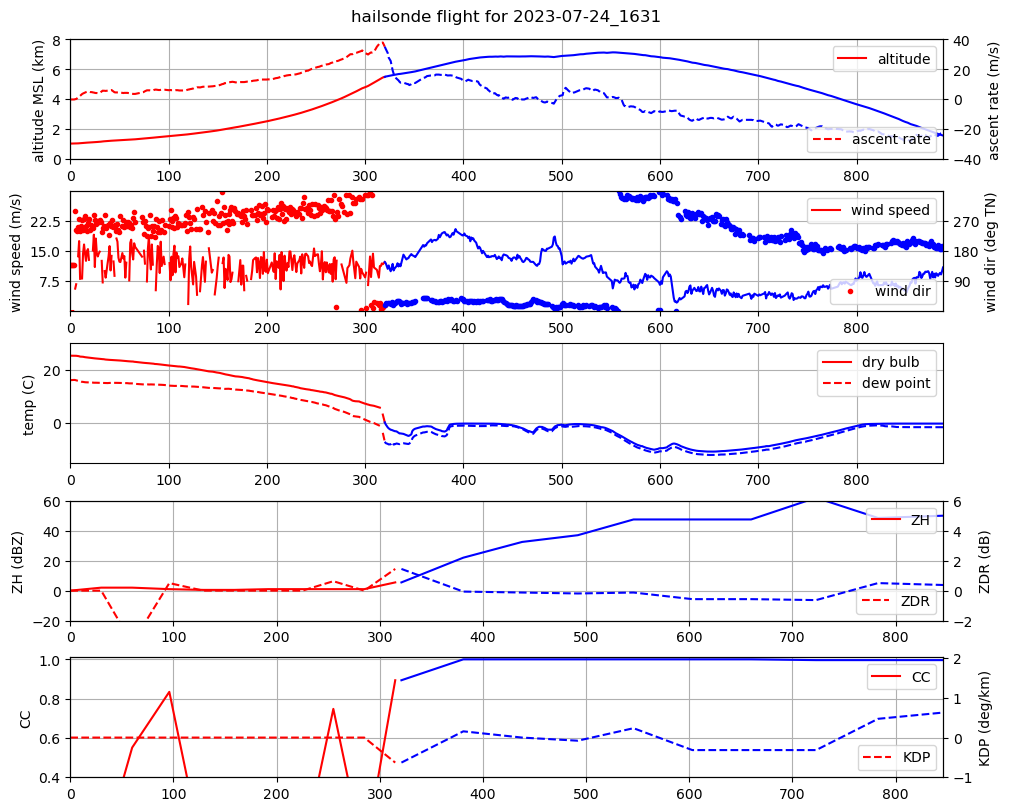

In [8]:
fig = pyplot.figure(constrained_layout = True, figsize = (10, 8))
fig.suptitle(f'hailsonde flight for {timestamp}')
ax = pyplot.subplot(511)
ax.plot(with_balloon_profile['time'],with_balloon_profile['hght']/1000, 'r-', label='altitude')
ax.plot(no_balloon_profile['time'],no_balloon_profile['hght']/1000, 'b-', label='_nolegend_')
ax.set_ylabel('altitude MSL (km)')
ax.set_ylim([0,8])
ax.set_xlim([0,np.max(no_balloon_profile['time'])])
ax2 = ax.twinx()
ax2.plot(with_balloon_profile['time'],with_balloon_profile['rise'], 'r--', label='ascent rate')
ax2.plot(no_balloon_profile['time'],no_balloon_profile['rise'], 'b--',label='_nolegend_')
ax2.set_ylabel('ascent rate (m/s)')
ax2.set_ylim([-40,40])
ax2.set_xlim([0,np.max(no_balloon_profile['time'])])
ax.legend()
ax2.legend(loc=4)
ax.grid()

ax = pyplot.subplot(512)
ax.plot(with_balloon_profile['time'],with_balloon_profile['wspd'], 'r-', label='wind speed')
ax.plot(no_balloon_profile['time'],no_balloon_profile['wspd'], 'b-', label='_nolegend_')
ax.set_ylabel('wind speed (m/s)')
ax.set_ylim([0,30])
ax.set_xlim([0,np.max(no_balloon_profile['time'])])
ax.set_yticks([7.5,15,22.5])
ax.grid()
ax2 = ax.twinx()
ax2.plot(with_balloon_profile['time'],with_balloon_profile['wdir']._magnitude, 'r.', label='wind dir')
ax2.plot(no_balloon_profile['time'],no_balloon_profile['wdir']._magnitude, 'b.', label='_nolegend_')
ax2.set_ylabel('wind dir (deg TN)')
ax2.set_ylim([0,360])
ax2.set_yticks([90,180,270])
ax2.set_xlim([0,np.max(no_balloon_profile['time'])])
ax.legend()
ax2.legend(loc=4)

ax = pyplot.subplot(513)
ax.plot(with_balloon_profile['time'],with_balloon_profile['tmpc'], 'r-', label='dry bulb')
ax.plot(no_balloon_profile['time'],no_balloon_profile['tmpc'], 'b-', label='_nolegend_')
ax.plot(with_balloon_profile['time'],with_balloon_profile['dwpc'], 'r--', label='dew point')
ax.plot(no_balloon_profile['time'],no_balloon_profile['dwpc'], 'b--', label='_nolegend_')
ax.set_ylabel('temp (C)')
ax.set_ylim([-15,30])
ax.set_xlim([0,np.max(no_balloon_profile['time'])])
ax.legend()
ax.grid()

ax = pyplot.subplot(514)
ax.plot(time_refl_profile1, radar_refl_profile1, 'r-', label='ZH')
ax.plot(time_refl_profile2, radar_refl_profile2, 'b-', label='_nolegend_')
ax.set_ylabel('ZH (dBZ)')
ax.set_ylim([-20,60])
ax2 = ax.twinx()
ax2.plot(time_refl_profile1, radar_zdr_profile1, 'r--', label='ZDR')
ax2.plot(time_refl_profile2, radar_zdr_profile2, 'b--', label='_nolegend_')
ax2.set_ylabel('ZDR (dB)')
ax2.set_ylim([-2,6])
ax.set_xlim([0,np.max(time_refl_profile2)])
ax2.set_xlim([0,np.max(time_refl_profile2)])
ax.legend(loc=1)
ax2.legend(loc=4)
ax.grid()

ax = pyplot.subplot(515)
ax.plot(time_refl_profile1, radar_rhv_profile1, 'r-', label='CC')
ax.plot(time_refl_profile2, radar_rhv_profile2, 'b-', label='_nolegend_')
ax.set_ylabel('CC')
ax.set_ylim([0.4,1.01])
ax2 = ax.twinx()
ax2.plot(time_refl_profile1, radar_kdp_profile1, 'r--', label='KDP')
ax2.plot(time_refl_profile2, radar_kdp_profile2, 'b--', label='_nolegend_')
ax2.set_ylabel('KDP (deg/km)')
ax2.set_ylim([-1,2.02])
ax.set_xlim([0,np.max(time_refl_profile1)])
ax.set_xlim([0,np.max(time_refl_profile2)])
ax.legend(loc=1)
ax2.legend(loc=4)
ax.grid()


pyplot.savefig(f'{output_image_path}/{sonde_id}_hailsonde_timeseries.png')